In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as f 
import torch.optim as optim

# 데이터 로딩 및 변환을 위한 torchvision
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 데이터 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import numpy as np

# 훈련진행상황 시각적으로 보여주는 유틸리티
from tqdm import tqdm

In [ ]:
# 변환
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)) # 정규화 과정
])


In [8]:
# 훈련데이터셋 다운로드 및 Dataset객체 생성
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# 테스트 데이터 셋 다운로드 및 Dataset 객체 생성
test_dataset = torchvision.datasets.MNIST(
    root = './data',
    train=False,
    download=True,
    transform=transform
)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:03<00:00, 2587294.49it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 148700.99it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:01<00:00, 1196271.81it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 5617967.79it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
# 훈련용 DataLoader
train_loader= DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size = 1000,
    shuffle=False,
    num_workers=2
)

-----Sample Images and Lables----------
Labels: 94290611


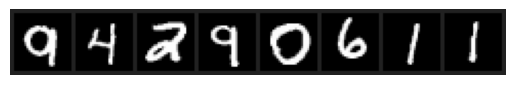

In [26]:
# 데이터 시각화를 위한 함수 저읭
# 데이터를 로더에서 꺼내서 시각화 : tensor로 변환된 상태, tensor,normalizer
def imshow(img_grid): # 데이터를 2차원으로 넣는다.
    # 원래 이미지로 변환
    # img_grid = img_grid*std + mean
    
    img_grid = img_grid*0.3081 +  0.1307
    # tensor -> ndarray
    npimg=img_grid.numpy()

    # (C,H,W) -> (H,W,C)로 차원 순서 변경해야함
    npimg=np.transpose(npimg,(1,2,0))

    plt.imshow(npimg)
    plt.axis('off')
    plt.show

# 훈련 데이터로더에서 이미지 한 배치를 가져오기
detaiter = iter(train_loader)
images,labels = next(detaiter)



# 8개 레이블 확인
print('-----Sample Images and Lables----------')
print('Labels:',''.join(f'{labels[j].item()}'for j in range(8)))

# 8개 이미지를 하나의 그리드로 만들어 시각화
imshow(torchvision.utils.make_grid(images[:8]))


In [27]:
class SimpleCNN(nn.Module): # 간단한 신경망이다
    def __init__(self): # 부품 생성
        super(SimpleCNN, self).__init__() # 주는 이유: 추적,디버깅 할때 필요함
        # pass

        # 첫번째 컨볼루션 블록 : Conv  -> Maxpool -> ReLU
        # 입력 채널:1(흑백), 출력채널:10, 커널(필터) 크기: 5
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=10,kernel_size=5)
        self.pool1 = nn.Maxpool2d(kernel_size=2)
        self.relu1 = nn.ReLU()


        # 두번째 블록 : 첫번째 블록에서 넘어논 넘을 받아야함
        # 입력 채널:10(첫번째 채널에서 output 채널이10이니까) , 출력 채널:20, 커널크기:5
        self.conv2 = nn.Conv2d(in_channels=10,out_channels=20,kernel_size=5)
        self.pool2 = nn.Maxpool2d(kernel_size=2)
        self.relu2 = nn.ReLU()

        # 완전 연결 계층(Fully Connected Layers)
        self.fc1 = nn.Linear(320,50) # 왜 320이 어떻게? forward에서 알 수 있음

        # 출력층
        self.fc2 = nn.Linear(50,10)


    def forward(self,x): # 조립 # x : (배치,1,28,28)
        x = self.conv1(x)   # (배치,10,24,24)
        x = self.relu1(x)   # 요소별 연산이랑 차원변화가 없다
        x = self.pool1(x)   # (배치,10,12,12) 

        # 두번째 블록 통과
        x = self.conv2(x)   # (배치, 20, 8, 8)
        x = self.relu2(x)
        x = self.pool2(x)   # (배치,20,4,4) # <주의>현장에서 에러나면 여기서 에러남

        # Flatten : 3D ---> 1D
        x = x.view(-1, 20*4*4) # 위에서 부터 쭉 내려와서 324 나옴, 나중에 마지막층에서 이 에러 많이 남


        # 완전 연결 계층 통과
        x = F.relu(self.fc1(x))  # (배치,50)

        # 출력층에 넘기기
        x = self.fc2(x)          # (배치,10)

        return x                 # 예측값(결과값)
